In [25]:
import numpy as np

# Read in and prepare text data

In [26]:
with open("goblet_book.txt", "r") as f:
    data = f.read()

data = list(data)

book_chars = list(set(data))
K = len(book_chars)

charToInd = {c:i for i,c in enumerate(book_chars)}
indToChar = {i:c for i,c in enumerate(book_chars)}

K  = len(indToChar)

In [27]:
def toString(encoded_text):
    return ''.join([indToChar[i] for i in encoded_text])

In [28]:
def oneHotEncode(x):
    Y = np.zeros((K, len(x)))
    for i,c in enumerate(x):
        Y[charToInd[c],i] = 1.0
    return Y

In [29]:
class RNN():
    def __init__(self, K, m=100, seed=123456789):
        np.random.seed(seed)

        self.K = K
        self.m = m
        self.sigma = 0.01

        self.weights = {}
        self.momentum = {}
        
        # Biases
        self.weights["b"] = np.zeros(shape=(self.m,1))
        self.weights["c"] = np.zeros(shape=(K,1))

        # Weights
        self.weights["U"] = np.random.randn(self.m, self.K) * self.sigma
        self.weights["W"] = np.random.randn(self.m, self.m) * self.sigma
        self.weights["V"] = np.random.randn(self.K, self.m) * self.sigma

        # Momentum
        for key, value in self.weights.items():
            self.momentum[key] = np.zeros(value.shape)

        # Set initial hidden state
        self.hprev = np.zeros(shape=(self.m,1))
    
    def cost(self, X, Y):
        P = self.forward(X)

        loss = -np.sum(Y * np.log(P))
        return loss
    
    def forward(self, X, train=False):

        hList = [self.hprev.copy()]
        aList = []
        pList = []

        for x in X.T:
            a = self.weights["W"] @ hList[-1] + self.weights["U"] @ x.reshape(-1,1) + self.weights["b"]
            h = np.tanh(a)
            o = self.weights["V"] @ h + self.weights["c"]
            p = np.exp(o) / np.sum(np.exp(o), axis=0)

            hList.append(h)
            aList.append(a)
            pList.append(p)

        H = np.hstack(hList)
        A = np.hstack(aList)
        P = np.hstack(pList)
        
        if train:
            self.hprev = H[:, -1].reshape(-1,1)
            # P: K x seq_length, H: m x seq_length+1, A: m x seq_length, O: K x seq_length
            return P, H, A
        else:
            return P
    
    def backward(self, X, Y):
            
            P, H, A = self.forward(X, train=True)
    
            g = P - Y #gradO
            gV = g @ H.T[1:]
            gc = np.sum(g, axis = 1).reshape(-1,1)
    
            gH = g.T[-1] @ self.weights["V"]
            gA = gH * (1 - np.square(np.tanh(A.T[-1])))

            lH = [gH]
            lA = [gA]
    
            # Page 42
            for gt, at in zip(g.T[-2::-1], A.T[-2::-1]):
                gH = gt @ self.weights["V"] + gA @ self.weights["W"]
                gA = gH * (1 - np.square(np.tanh(at)))

                lH.append(gH)
                lA.append(gA)

            gH = np.vstack(lH[::-1]).T
            gA = np.vstack(lA[::-1]).T

            gW = gA @ H.T[:-1]
            gU = gA @ X.T
            gb = np.sum(gA, axis = 1).reshape(-1,1)

            return {"W":gW, "U":gU, "V":gV, "b":gb, "c":gc}

    
    def synth(self, x0, n):

        h = self.hprev
        x = x0

        for i in range(n):
            a = self.weights["W"] @ h + self.weights["U"] @ x[:,-1].reshape(-1,1) + self.weights["b"]
            h = np.tanh(a)
            o = self.weights["V"] @ h + self.weights["c"]
            p = np.exp(o) / np.sum(np.exp(o), axis=0)
            idx = np.random.choice(range(self.K),p=np.squeeze(p))
            newX = np.zeros(shape=(self.K,1))
            newX[idx,0] = 1
            x = np.c_[x,newX]
        
        return [np.argmax(c) for c in x.T]
    
    def computeGradsNumerical(self, X, Y, eps):
        grads = {}
        
        for name, weight in self.weights.items():
            shape = weight.shape
            wPerturb = np.zeros(shape)
            wGradsNum = np.zeros(shape)
            wOriginal = weight.copy()
            
            for i in range(shape[0]):
                for j in range(shape[1]):
                    # Perturb the weight negatively
                    wPerturb[i, j] = eps
                    self.weights[name] = wOriginal - wPerturb
                    cost1 = self.cost(X, Y)
                    
                    # Perturb the weight positively
                    self.weights[name] = wOriginal + wPerturb
                    cost2 = self.cost(X, Y)
                    
                    # Calculate the gradient numerically
                    wGradsNum[i, j] = (cost2 - cost1) / (2 * eps)
                    
                    # Reset the perturbation
                    wPerturb[i, j] = 0
            
            # Store the calculated gradients
            grads[name] = wGradsNum
            
            # Reset the weight to the original
            self.weights[name] = wOriginal
        
        return grads
        
    def train(self, X, Y, eta=0.1):
        eps = 1e-8
        grads = self.backward(X, Y)

        for key, weight in self.weights.items():

            # Clip as per instructions
            grads[key] = np.clip(grads[key], -5, 5)

            self.momentum[key] += np.square(grads[key])
            
            weight -= eta * grads[key] / np.sqrt(self.momentum[key] + eps)




In [30]:
m = 100
eta = 0.1
seq_length = 25

# 0.3

In [31]:
x = oneHotEncode(["a"])
model = RNN(K, m=5)

In [32]:
toString(model.synth(x, 20))

'aiQyX19d1-C"\tST_iXsiY'

# 0.4

In [33]:
def relerr(ga, gn, eps=1e-6):
        """
        Calculates the relative error between two vectors.

        Args:
            ga (numpy.ndarray): Analytical gradient.
            gn (numpy.ndarray): Numerical gradient.
            eps (float, optional): A small value to avoid division by zero. Defaults to 1e-6.

        Returns:
            float: The relative error between ga and gn.
        """
        
        diff = np.linalg.norm(ga - gn)
        norma = np.linalg.norm(ga)
        normn = np.linalg.norm(gn)
        numer = max(eps, norma + normn)
        return diff / numer

In [34]:
Xchars = data[0:seq_length]
Ychars = data[1:seq_length+1]

X = oneHotEncode(Xchars) # K x seq_length
Y = oneHotEncode(Ychars) # K x seq_length

In [35]:
P, H, A = model.forward(X, train=True)

In [36]:
P.shape, H.shape, A.shape
# P: K x seq_length, H: m x seq_length+1, A: m x seq_length

((80, 25), (5, 26), (5, 25))

# Numerical sanity check

for m=5

In [37]:
angrads = model.backward(X, Y)
numgrads = model.computeGradsNumerical(X, Y, 1e-4)
for key in numgrads.keys():
    print(key)
    print(relerr(angrads[key], numgrads[key]))

b
1.4749889309780247e-09
c
3.147934664526794e-10
U
2.5802235915813572e-09
W
5.907033780816311e-08
V
5.345316230238328e-09


# 0.5 - Training Loop

In [38]:
m = 100
eta = 0.1
seq_length = 25

# Important! For reproducibility set PYTHONHASHSEED=0 on execution, and find good session seed.
# Ideally get step 1000 loss to ~76
model = RNN(K, m=m, seed=41)
dataSetSize = len(data)

# Epoch Counter
epoch = 0

# Text position counter
e = 0

# Initialize smooth loss
Xchars = data[0:seq_length]
Ychars = data[1:seq_length+1]
X = oneHotEncode(Xchars) # K x seq_length
Y = oneHotEncode(Ychars) # K x seq_length
lossSmooth = model.cost(X,Y)

lossHistory = []
synthHistory = {}
lossBest = lossSmooth
weightBest = model.weights.copy()
iterCount = 0

print(f"==== Epoch {0} ====")
while epoch < 6:
    Xchars = data[e:e+seq_length]
    Ychars = data[e+1:e+seq_length+1]

    X = oneHotEncode(Xchars) # K x seq_length
    Y = oneHotEncode(Ychars) # K x seq_length

    model.train(X, Y, eta=eta)

    loss = model.cost(X,Y)
    lossSmooth = 0.999*lossSmooth + 0.001*loss

    # Checkpoint when loss is improved
    if lossSmooth < lossBest:
        weightsBest = model.weights.copy()
        lossBest = lossSmooth
    
    # Log loss every 100 steps
    if iterCount % 100 == 0:
        lossHistory.append(lossSmooth)

    # Synth 200 chars of text every 1000 steps
    if iterCount % 10000 == 0:
        txtenc = model.synth(X, 200)[seq_length:]

        txt = "".join([indToChar[ind] for ind in txtenc])
        if iterCount <= 100000:
            synthHistory[iterCount] = txt
        print("Step: ", iterCount, " loss: ",lossSmooth,"\n")
        print(txt,"\n")

    e += seq_length
    iterCount += 1

    if e + seq_length >= dataSetSize:
        e = 0
        epoch += 1
        print(f"\n==== Epoch {epoch} ====\n")
        model.hprev = np.zeros(shape=(m,1))
        

    
    
    

==== Epoch 0 ====
Step:  0  loss:  109.53701347501567 

XSU7CaMg	3VmV:TvtjogmvS(w}k26:f2FW?ymZS_•IüpsPh22üBjF7(Kü9gj-TSIFdeHLejZ^UBG	2OI7Rga^yqhLyCü0yhCS,lh^zsMM::a172oqEoiaZ:Qs0Vr)LUODbn2/ZxHo)pN(xGBi
iZ,fX0dHI6(gRt_ L?rymo^•u66
qF)9ixcfcmz;xx:FCüLLl}Cj!R 

Step:  10000  loss:  49.241641527023575 

Arire t makrarbem. ere ats Tfeavart )ringich han the of Bfestry, the sar phacorst Harming roul caod acr.
The kyighterine to lang surcer cor's and samy to mannemexpnere" said .e. Salling," said alle, S 

Step:  20000  loss:  47.71613609260471 

ins elcofingly. ."
"the net owited dit Haid wirc" saig eat and if the fid io her sayterstrink-" Satring brenmelf."
"Itk-"phem he wet," . Harry come's?"
... miin tuttre brat soubly eeplystar't er-"Teel 

Step:  30000  loss:  47.32423551057326 

ewer, stoon, miretel in thear sar not whonr her youeggensoor lound was mindy's cawmen more compingion, deerel repe him ale was of a were of tand..
"Ho wat the foibed.  To fright'he on tarterstersing o 

Step:  4

In [39]:
for iter, txt in synthHistory.items():
    print(f"Step: {iter}\n{txt}\n")

Step: 0
XSU7CaMg	3VmV:TvtjogmvS(w}k26:f2FW?ymZS_•IüpsPh22üBjF7(Kü9gj-TSIFdeHLejZ^UBG	2OI7Rga^yqhLyCü0yhCS,lh^zsMM::a172oqEoiaZ:Qs0Vr)LUODbn2/ZxHo)pN(xGBi
iZ,fX0dHI6(gRt_ L?rymo^•u66
qF)9ixcfcmz;xx:FCüLLl}Cj!R

Step: 10000
Arire t makrarbem. ere ats Tfeavart )ringich han the of Bfestry, the sar phacorst Harming roul caod acr.
The kyighterine to lang surcer cor's and samy to mannemexpnere" said .e. Salling," said alle, S

Step: 20000
ins elcofingly. ."
"the net owited dit Haid wirc" saig eat and if the fid io her sayterstrink-" Satring brenmelf."
"Itk-"phem he wet," . Harry come's?"
... miin tuttre brat soubly eeplystar't er-"Teel

Step: 30000
ewer, stoon, miretel in thear sar not whonr her youeggensoor lound was mindy's cawmen more compingion, deerel repe him ale was of a were of tand..
"Ho wat the foibed.  To fright'he on tarterstersing o

Step: 40000
doccor; beto lrnith upellirge hich thin't torredlinged bar odernth greferught wast formor Harry walden.  And prefartem a his up tore hea

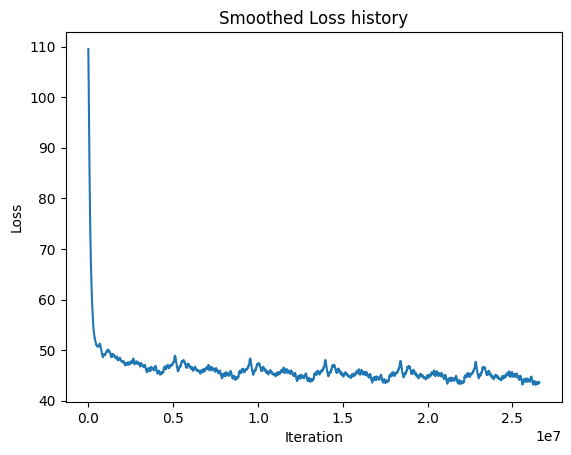

In [47]:
#plot loss history
import matplotlib.pyplot as plt
x = [10000*i for i in range(len(lossHistory))]
plt.plot(x, lossHistory)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Smoothed Loss history")
plt.show()

In [48]:
model.weights = weightsBest
txtenc = model.synth(X, 1000)[seq_length:]
txt = "".join([indToChar[ind] for ind in txtenc])
print(txt)

he reave tis at a herselt out knsite.  The hy with Firht slew ter.  He reelfy, at hessise spint the Goold Perser," Ron word it ir as shioks.  Hogmace's as with touonedly at a very over fightly, and waines, he let me the Sido the Gey.
Bed good Hermione there dreve," he's staring a sidiso, I at the don't had and had stors Mont don't, and de my levired at Eot all rean.
"Mr he keath Harry.
"Ceflyoke?"
"Gobigue and been."
Ferting yough cuming fingled from talkes ussim.  Malfed of he was everyones, with corrizared disent poare of put yold a ner.
"I was for Been to con at the had of the Worttall said.   Daginging, lestorouse ian dourd, and it wand, and sold!  He the way hand tayed to so to got anything to med. But lins and and we the now ne toward Uncely, dundemide rookicaling thim, Harry but scared porpLon't finger mf ofgendand here-led-on.
"
"Sall one to lack eacing the Ron.
"I with him.
"I con't?"  He pround youl two to have all his lamso dark one of scate just owerce, theor she cenate her

In [49]:
# Print the best loss
print(f"Best loss: {lossBest}")

Best loss: 43.10980083088671
